In [62]:
from database import db_query
import pandas as pd

In [63]:
df = db_query("SELECT * FROM twitter_forecast")
df = pd.DataFrame(df)


In [64]:
df

,id,tweet_id,observation_time,author,tweet_time,views,likes,retweets,comments,url,created_at,author_followers_count,author_following_count,author_tweet_count,author_created_at,is_blue_verified,checkmark_color,text
0,5069,1896310473915802080,2025-03-03 00:27:12.585,beyzanurapaydin,2025-03-02 21:23:43,6700,60,18,1,https://twitter.com/i/status/1896310473915802080,2025-03-03 00:38:01.738038,NaN,NaN,NaN,NaT,True,blue,Stacy Martin at the #Oscars2025
1,5070,1896226783785279812,2025-03-03 00:29:15.476,offgriddesigner,2025-03-02 15:51:10,10000,1317,326,51,https://twitter.com/i/status/1896226783785279812,2025-03-03 00:38:01.738038,NaN,NaN,NaN,NaT,True,blue,"The King of England, constitutionally required..."
2,5071,1896256464114868467,2025-03-03 00:26:13.425,gaulicsmith,2025-03-02 17:49:06,867,10,0,0,https://twitter.com/i/status/1896256464114868467,2025-03-03 00:38:01.738038,NaN,NaN,NaN,NaT,True,blue,Interesting study: “EU imports of Russian foss...
3,5072,1896342691761537503,2025-03-03 00:27:09.382,rtvenoticias,2025-03-02 23:31:44,3500,11,5,0,https://twitter.com/i/status/1896342691761537503,2025-03-03 00:38:01.738038,NaN,NaN,NaN,NaT,True,blue,Las cantantes Miley Cyrus y Doja Cat son algun...
4,5073,1895626478479647117,2025-03-03 00:31:56.500,tzyunjz,2025-03-01 00:05:46,61000,5098,386,17,https://twitter.com/i/status/1895626478479647117,2025-03-03 00:38:01.738038,NaN,NaN,NaN,NaT,False,None,eunchae went through one of the biggest hate t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462,5550,1896325109704757601,2025-03-03 00:28:37.029,GoalsXtra,2025-03-02 22:21:52,6600,32,4,1,https://twitter.com/i/status/1896325109704757601,2025-03-03 00:38:01.738038,61362.0,216.0,3473.0,2012-08-03,True,blue,UMAR SADIQ AFTER HIS SECOND GOAL !
1463,5206,1896229009962209339,2025-03-03 00:23:30.697,ChrisWillx,2025-03-02 16:00:00,18000,414,27,54,https://twitter.com/i/status/1896229009962209339,2025-03-03 00:38:01.738038,277836.0,104.0,35995.0,2009-03-28,True,blue,Don’t strangle your passions in return for an ...
1464,5170,1896191908080484429,2025-03-03 00:25:24.647,GarbageHuman24,2025-03-02 13:32:35,507000,17544,1124,158,https://twitter.com/i/status/1896191908080484429,2025-03-03 00:38:01.738038,359816.0,979.0,12318.0,2018-03-13,True,blue,Charlie Kirk agrees that if America were 90% I...
1465,5815,1896331367803486472,2025-03-03 00:26:44.306,XAVIAERD,2025-03-02 22:46:44,14000,224,7,19,https://twitter.com/i/status/1896331367803486472,2025-03-03 00:38:01.738038,256225.0,906.0,11155.0,2020-09-16,True,blue,She looks so lovely and elegant. This is the k...


In [65]:
df["observation_time"] = pd.to_datetime(df["observation_time"])
df["tweet_time"] = pd.to_datetime(df["tweet_time"])
df["age_hours"] = (df["observation_time"] - df["tweet_time"]).dt.total_seconds() / 3600
df["author_created_at"] = pd.to_datetime(df["author_created_at"])
df["author_age_years"] = (df["observation_time"] - df["author_created_at"]).dt.total_seconds() / (3600 * 24 * 365)


In [66]:
# constraints
MIN_HOURS = 1
MAX_HOURS = 48
MIN_VIEWS = 20

mask = (df["age_hours"] >= MIN_HOURS) & (df["age_hours"] <= MAX_HOURS) & (df["views"] >= MIN_VIEWS)
df = df[mask].copy()
len(df)

1283

In [67]:
num_features = [
    "author_followers_count",
    "author_following_count",
    "author_tweet_count",
    "age_hours",
    "author_age_years"
]

cat_features = []
target = "views"

text_features = ["text"]

In [68]:


df["text"] = df["text"].apply(preprocess_text)

In [69]:
import numpy as np

def transform_features(x):
    x["author_followers_count"] = np.log1p(x["author_followers_count"])
    x["author_following_count"] = np.log1p(x["author_following_count"])
    x["author_tweet_count"] = np.log1p(x["author_tweet_count"])
    x["author_age_years"] = np.log1p(x["author_age_years"])
    x["age_hours"] = np.log1p(x["age_hours"])
    x["text"] = x["text"].fillna("")
    return x
    

In [70]:
from sklearn.model_selection import GroupKFold
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

n_text_features = 500
tfidf = TfidfVectorizer(max_features=n_text_features)
text_feat = [f"text_{i}" for i in range(n_text_features)]



n_splits = 5  # Number of folds
group_kfold = GroupKFold(n_splits=n_splits)

# Use the defined features from earlier
X = df[num_features + cat_features + text_features].copy()
X = transform_features(X)
y = np.log1p(df[target])

# Use author as the group
groups = df['author']

# Get train and test indices for the first fold
train_idx, test_idx = next(group_kfold.split(X, y, groups))

# Create train and test sets
# Create train and test sets
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Transform text features using TF-IDF
X_train_text_features = tfidf.fit_transform(X_train["text"])
X_test_text_features = tfidf.transform(X_test["text"])

# Convert sparse matrix to DataFrame and concatenate with original features
X_train_text_df = pd.DataFrame(
    X_train_text_features.toarray(),
    columns=text_feat,
    index=X_train.index
)
X_test_text_df = pd.DataFrame(
    X_test_text_features.toarray(),
    columns=text_feat,
    index=X_test.index
)

# Drop the original text column and concatenate with TF-IDF features
X_train = X_train.drop(columns=["text"]).join(X_train_text_df)
X_test = X_test.drop(columns=["text"]).join(X_test_text_df)


# Print split information
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of unique authors in training: {X_train.index.map(df['author']).nunique()}")
print(f"Number of unique authors in test: {X_test.index.map(df['author']).nunique()}")
print(f"Features used: {X.columns.tolist()}")

Training set size: 1026
Test set size: 257
Number of unique authors in training: 833
Number of unique authors in test: 206
Features used: ['author_followers_count', 'author_following_count', 'author_tweet_count', 'age_hours', 'author_age_years', 'text']


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 57
[LightGBM] [Info] Start training from score 10.362912
Root Mean Squared Error: 2.66
Mean Absolute Error: 2.08
R² Score: 0.0272


/opt/miniconda3/envs/tweet-forecast/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


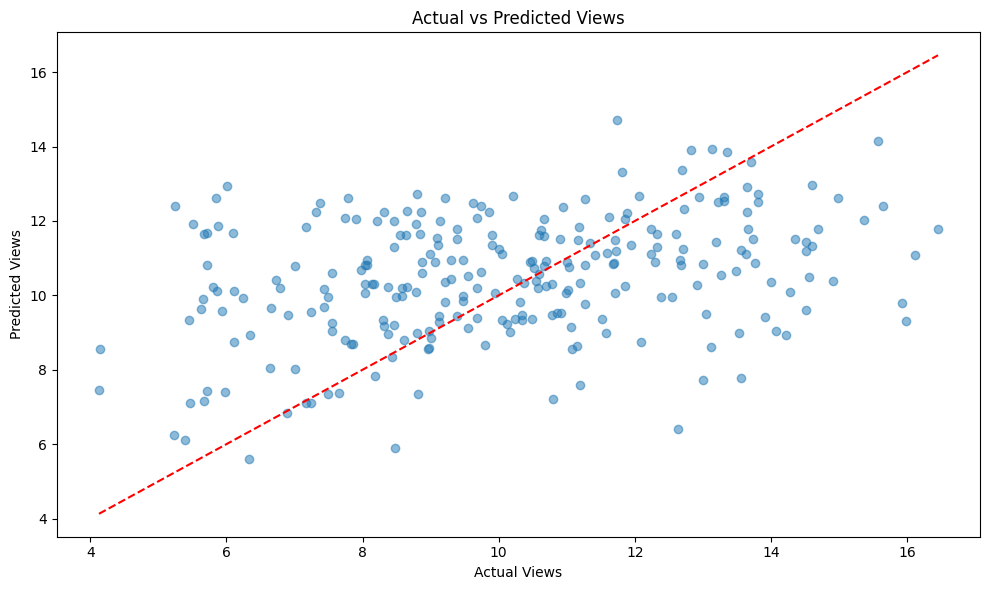

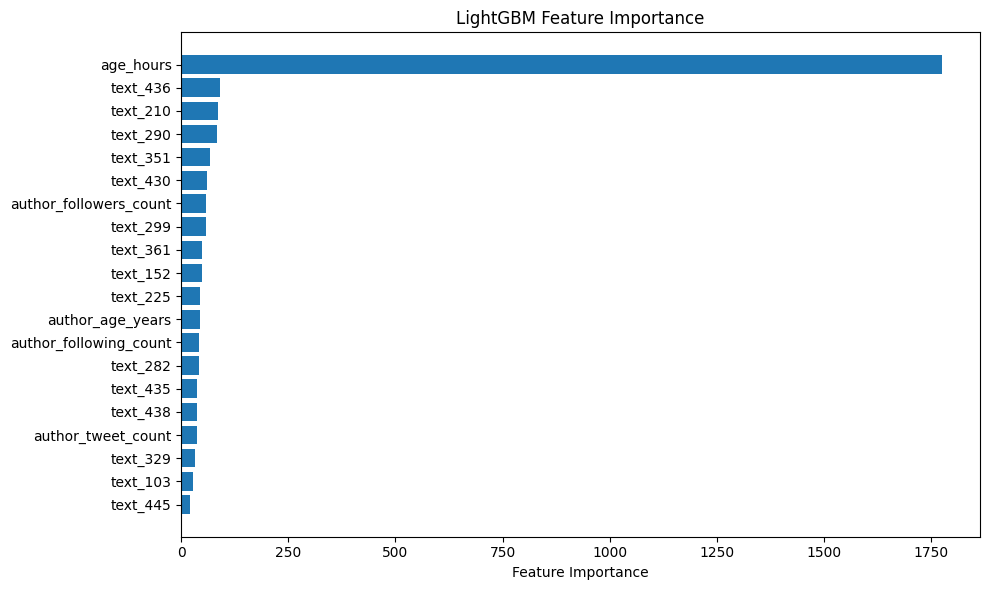

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 257, number of used features: 5
[LightGBM] [Info] Start training from score 10.099204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/opt/miniconda3/envs/tweet-forecast/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


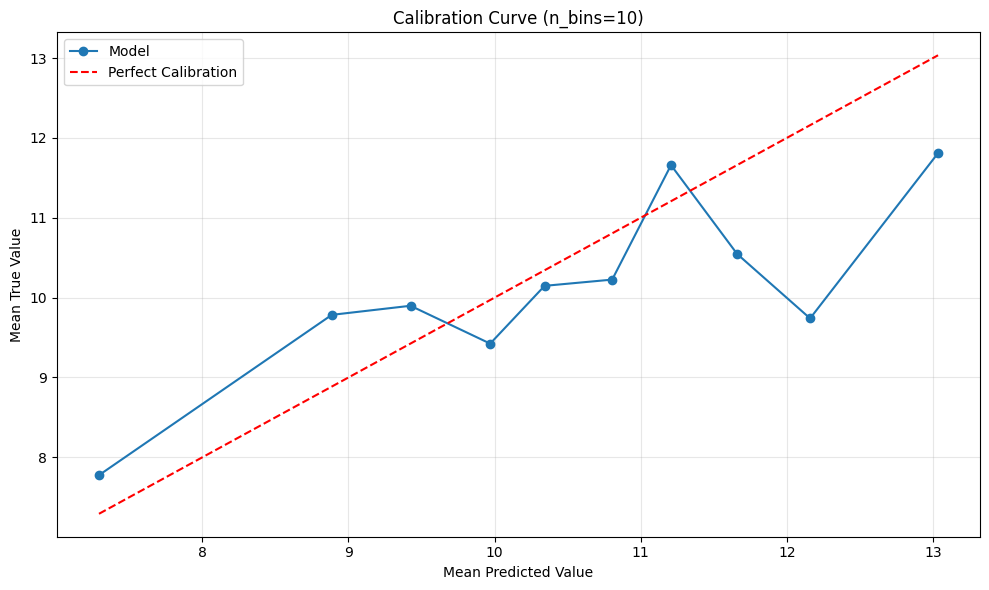

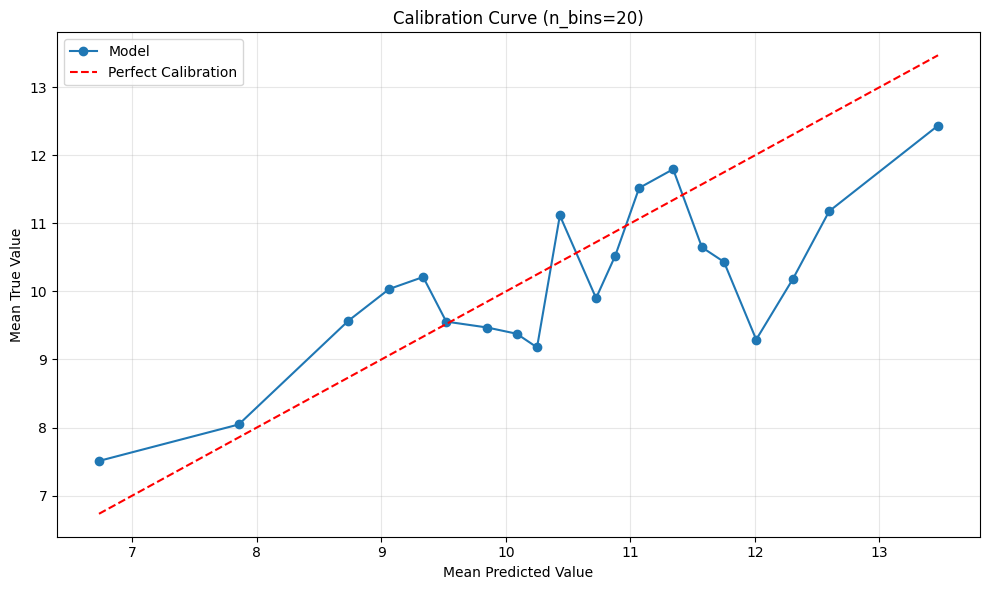

In [71]:
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Create a LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'random_state': 42
}

# Create a pipeline with preprocessing and model
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', lgb.LGBMRegressor(**params))
])

# Train the model on the first fold
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('Actual vs Predicted Views')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = model.named_steps['regressor'].feature_importances_
features = X_train.columns  # Use X_train.columns instead of X.columns

# Plot only top 20 features if there are many
plt.figure(figsize=(10, 6))
if len(feature_importance) > 20:
    # Sort and get indices of top 20 features
    sorted_idx = np.argsort(feature_importance)[-20:]
else:
    sorted_idx = np.argsort(feature_importance)
    
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# Train final model on all data
final_model = model.fit(X_test, y_test)

# Save the model
joblib.dump(final_model, 'twitter_views_predictor.joblib')
print("Model saved as 'twitter_views_predictor.joblib'")

# Example prediction function
def predict_views(new_data):
    # Check if the data has the right format
    if 'text' in new_data.columns and not any(col.startswith('text_') for col in new_data.columns):
        # We need to transform the text using the same TF-IDF vectorizer
        text_features = tfidf.transform(new_data['text'])
        
        # Convert to DataFrame with proper column names
        text_df = pd.DataFrame(
            text_features.toarray(),
            columns=text_feat,
            index=new_data.index
        )
        
        # Drop the original text column and join with TF-IDF features
        new_data = new_data.drop(columns=['text']).join(text_df)
    
    return final_model.predict(new_data)

# Example usage
print("\nExample prediction:")
sample_data = X.iloc[:5].copy()  # Just for demonstration, use copy to avoid modifying original

# Make sure sample_data has the same features as what the model expects
if 'text' in sample_data.columns and not any(col.startswith('text_') for col in sample_data.columns):
    # Transform text features
    text_features = tfidf.transform(sample_data['text'])
    
    # Convert to DataFrame with proper column names
    text_df = pd.DataFrame(
        text_features.toarray(),
        columns=text_feat,
        index=sample_data.index
    )
    
    # Drop the original text column and join with TF-IDF features
    sample_data = sample_data.drop(columns=['text']).join(text_df)

predicted_views = predict_views(sample_data)
actual_views = y.iloc[:5]

for i, (pred, actual) in enumerate(zip(predicted_views, actual_views)):
    print(f"Sample {i+1}: Predicted views = {np.expm1(pred):.0f}, Actual views = {np.expm1(actual):.0f}")



from sklearn.calibration import calibration_curve
import pandas as pd

def plot_calibration_curve(y_true, y_pred, n_bins=10):
    calib_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    
    # Create ntile bins with duplicates='drop' to handle duplicate bin edges
    calib_df['bin'] = pd.qcut(calib_df['y_pred'], q=n_bins, labels=False, duplicates='drop')
    
    # Calculate mean predicted and true values per bin
    bin_stats = calib_df.groupby('bin').agg({
        'y_pred': 'mean',
        'y_true': 'mean'
    }).reset_index()
    
    # Plot calibration curve
    plt.figure(figsize=(10, 6))
    plt.plot(bin_stats['y_pred'], bin_stats['y_true'], marker='o', linestyle='-', label='Model')
    
    # Plot perfect calibration line
    min_val = min(bin_stats['y_pred'].min(), bin_stats['y_true'].min())
    max_val = max(bin_stats['y_pred'].max(), bin_stats['y_true'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Calibration')
    
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Mean True Value')
    plt.title(f'Calibration Curve (n_bins={n_bins})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return bin_stats


baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("\nBaseline Model (Mean Prediction):")
print(f"Baseline Root Mean Squared Error: {baseline_rmse:.2f}")
print(f"Baseline Mean Absolute Error: {baseline_mae:.2f}")
print(f"Baseline R² Score: {baseline_r2:.4f}")
print(f"Model improvement over baseline (RMSE): {(baseline_rmse - rmse) / baseline_rmse * 100:.2f}%")

# Plot calibration curve with different bin sizes
bin_stats_10 = plot_calibration_curve(y_test, y_pred, n_bins=10)
bin_stats_20 = plot_calibration_curve(y_test, y_pred, n_bins=20)


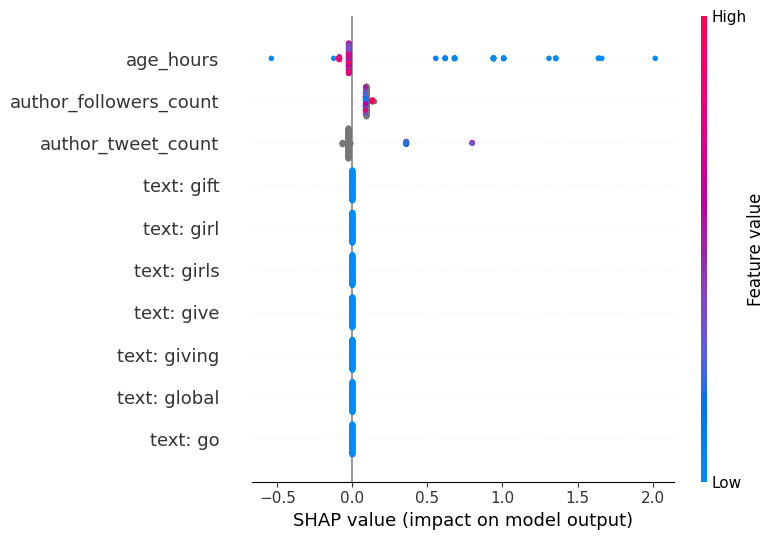

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

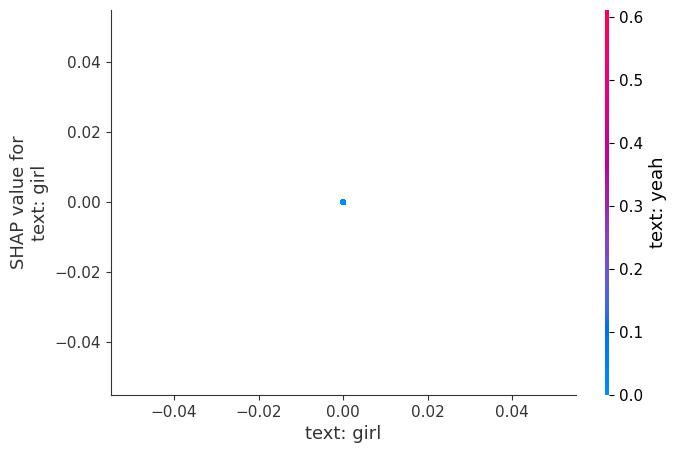

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

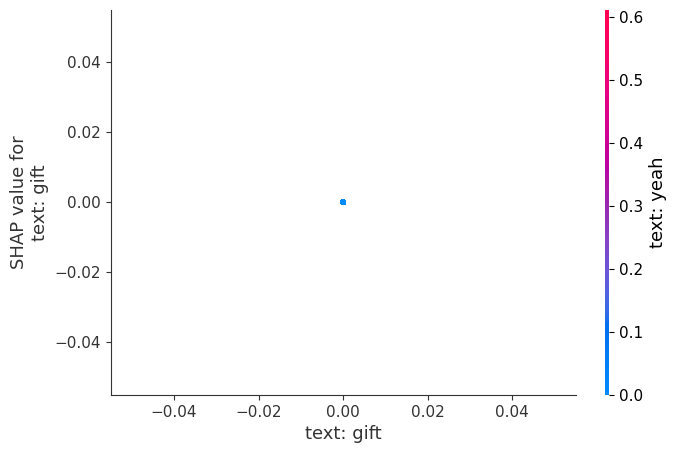

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

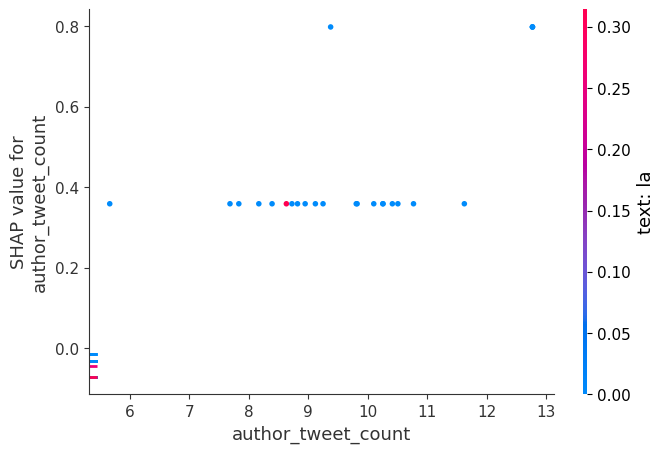

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

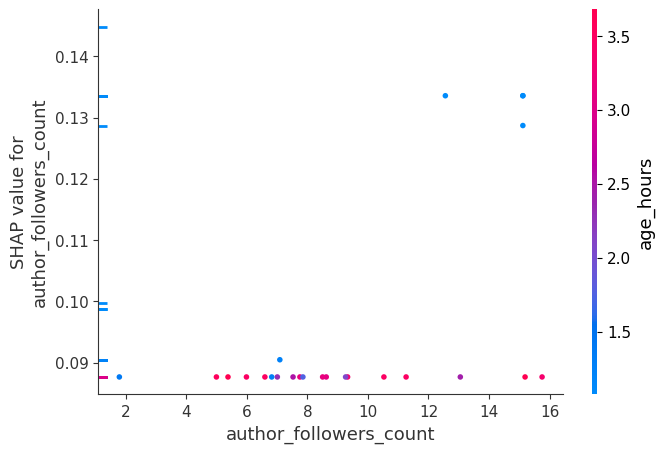

<Figure size 640x480 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

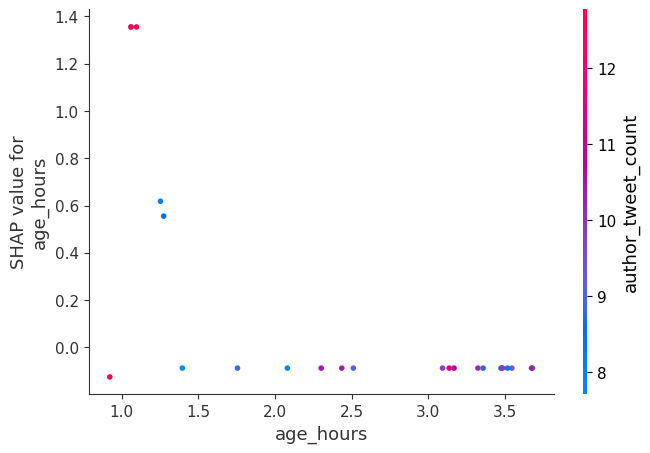

<Figure size 640x480 with 0 Axes>

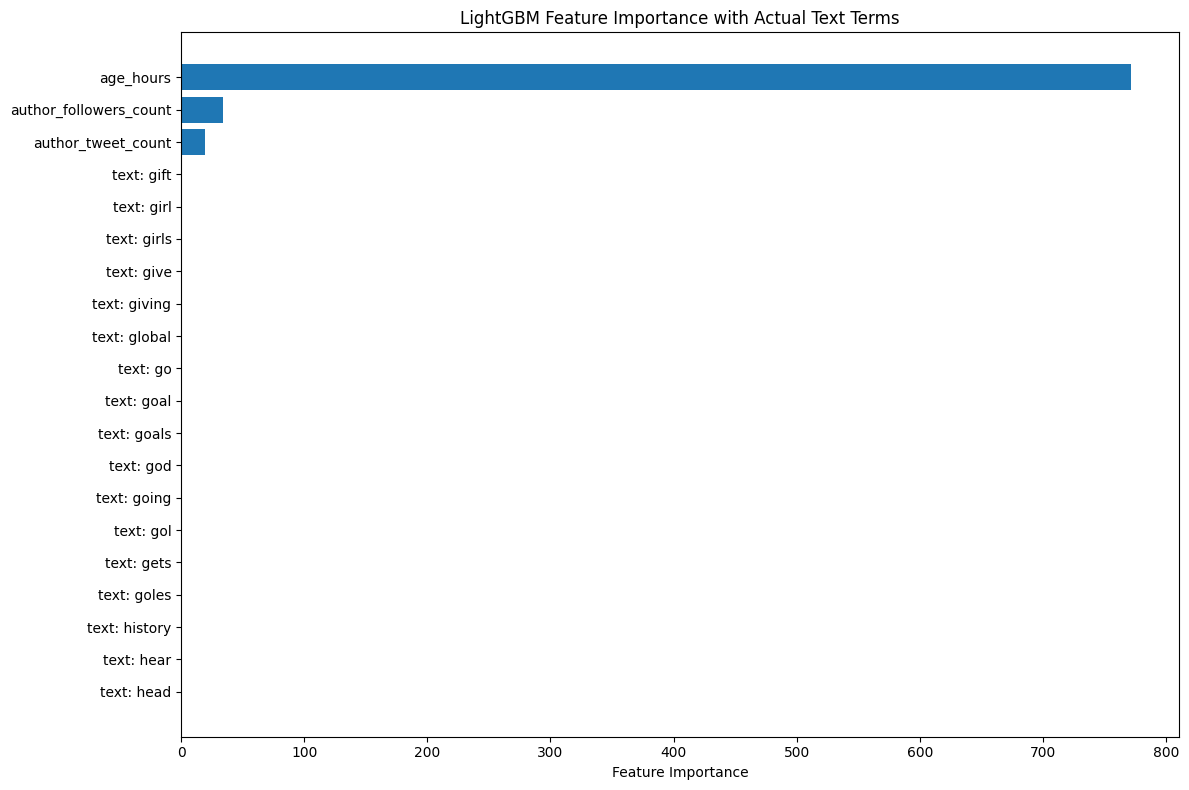

In [72]:
import shap

# Create a SHAP explainer for the model
explainer = shap.TreeExplainer(model.named_steps['regressor'])

# Calculate SHAP values for the test set
X_test_array = X_test.values
shap_values = explainer.shap_values(X_test_array)

# Create a mapping from feature index to actual text terms
text_feature_names = X_test.columns.tolist()
for i, col in enumerate(text_feature_names):
    if col.startswith('text_'):
        # Get the actual word this feature represents from the TF-IDF vectorizer
        feature_idx = int(col.split('_')[1])
        if hasattr(tfidf, 'get_feature_names_out'):
            # For newer scikit-learn versions
            all_feature_names = tfidf.get_feature_names_out()
        else:
            # For older scikit-learn versions
            all_feature_names = tfidf.get_feature_names()
        
        if feature_idx < len(all_feature_names):
            text_feature_names[i] = f"text: {all_feature_names[feature_idx]}"

# Summary plot of SHAP values with actual text terms
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_array, feature_names=text_feature_names, max_display=10)
plt.tight_layout()
plt.show()

# Get top 5 features by importance
feature_importance = model.named_steps['regressor'].feature_importances_
top_features_idx = np.argsort(feature_importance)[-5:]
top_features = [X_test.columns[i] for i in top_features_idx]

# Detailed SHAP dependence plots for top features
for feature_idx, feature in enumerate(top_features):
    feature_pos = list(X_test.columns).index(feature)
    plt.figure(figsize=(10, 6))
    # Use the text_feature_names for better labels
    shap.dependence_plot(feature_pos, shap_values, X_test_array, 
                         feature_names=text_feature_names)
    plt.tight_layout()
    plt.show()

# Also create a more readable feature importance plot
plt.figure(figsize=(12, 8))
if len(feature_importance) > 20:
    # Sort and get indices of top 20 features
    sorted_idx = np.argsort(feature_importance)[-20:]
else:
    sorted_idx = np.argsort(feature_importance)
    
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [text_feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('LightGBM Feature Importance with Actual Text Terms')
plt.tight_layout()
plt.show()